In [295]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [296]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from abc import ABC, abstractmethod
from typing import List
from scipy.stats import norm

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator, FuncFormatter
import seaborn as sns
from collections import Counter
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay
import datetime
import sys
import os
import tqdm

import torch
from typing import Tuple

In [351]:
def calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred):
  print("Train RMSE = %.4f" % metrics.mean_squared_error(y_train, y_train_pred, squared=False))
  print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))
  print("Test MAPE = %.4f" % metrics.mean_absolute_percentage_error(y_test, y_test_pred))
  print("Test R^2 = %.4f" % metrics.r2_score(np.array(y_test), y_test_pred))

In [352]:
dataframe = pd.read_csv('ts_project_data.csv')

In [360]:
X_train_d, X_test_d, y_train, y_test = train_test_split(dataframe.drop(columns=['Balance', 'Unnamed: 0']), dataframe['Balance'], test_size=0.05, random_state=1)

X_train = X_train_d.drop(columns=['Date'])
X_test = X_test_d.drop(columns=['Date'])

xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, nthread=4, seed=1)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
calc_metrics(y_train, y_train_pred,y_test, y_test_pred)

Train RMSE = 0.0583
Test RMSE = 0.0683
Test MAPE = 12416447817570.8457
Test R^2 = 0.9320


In [507]:
class CusumDetection():
    def __init__(self, threshold=1, alpha=0.01, beta=0.01, mean_diff = -0.3):
        super().__init__()
        self.mean_sum = None
        self.var_sum = None
        self.mean_estimate = 0
        self.var_estimate = 1
        self.alpha = alpha
        self.beta = beta
        self.mean_diff = mean_diff
        self.threshold = threshold
        self.stat = 0
        self.anoms = []
        self.stat_history = []

    def update(self, new_value):
        if self.mean_sum:
            # Отклонения среднего
            self.mean_estimate = self.mean_sum / self.mean_weights_sum
            self.mean_sum = (1 - self.alpha) * self.mean_sum + new_value
            self.mean_weights_sum = (1 - self.alpha) * self.mean_weights_sum + 1.0

            # Отклонения дисперсии
            self.var_estimate = self.var_sum / self.var_weights_sum
            self.normalized_value = (new_value - self.mean_estimate) / np.sqrt(self.var_estimate)
            self.var_sum = (1 - self.beta) * self.var_sum + (self.normalized_value - self.mean_estimate)**2
            self.var_weights_sum = (1 - self.beta) * self.var_weights_sum + 1.0

        # Если это первое значение
        else:
            self.mean_sum = new_value
            self.mean_weights_sum = 1.0
            self.normalized_value = (new_value - self.mean_estimate) / np.sqrt(self.var_estimate)
            self.var_sum = (self.normalized_value - self.mean_estimate)**2
            self.var_weights_sum = 1.0

        zeta_k = np.log(norm.pdf(self.normalized_value, self.mean_diff, 1) / norm.pdf(self.normalized_value, 0., 1))
        self.stat = max(0, self.stat + zeta_k)

    def check(self, new_value):
        self.update(new_value)
        self.stat_history.append(self.stat)
        if self.stat > self.threshold:
            self.anoms.append(1)
        else: self.anoms.append(0)

    def load_old(self, data):
        for i in data:
            self.update(i)

    def find_all(self, data):
        for i in data:
            self.check(i)
        return self.anoms

    def cleaning(self):
        self.mean_estimate = 0
        self.var_estimate = 1
        self.mean_sum = None
        self.var_sum = None
        self.stat = 0
        self.anoms = []
        self.stat_history = []

    def hist(self):
        return self.stat_history

In [590]:
# Так как мы переобучаемся каждый день, то нам нет смысла рефитаться при появлении разладки
# У нас не будет новых данных для рефита модели, так что придется просто переходить в ручной режим

def check_model (y_train, y_test_pred, a = 0.2, b = 0.2, mean_diff = 0.3, threshold = 1, graphics = False):
    detector = CusumDetection(threshold=threshold, alpha=a, beta=b, mean_diff = mean_diff)
    detector.load_old(y_train)
    razl_test_pol = detector.find_all(y_test_pred)
    if graphics == True:
        plt.plot(detector.hist(), label = 'Положительные отклонения')
    detector.cleaning()

    detector = CusumDetection(threshold=threshold, alpha=a, beta=b, mean_diff = - mean_diff)
    detector.load_old(y_train)
    razl_test_neg = detector.find_all(y_test_pred)
    if graphics == True:
        plt.plot(detector.hist(), label = 'Отрицательные отклонения')
        plt.xlabel('Время')
        plt.ylabel('Значения статистики')
        plt.legend()
        plt.show

    detector.cleaning()

    try:
        index_razl_pol = razl_test_pol.index(1)
    except: index_razl_pol = len(y_train)+100
    try:
        index_razl_neg = razl_test_neg.index(1)
    except: index_razl_neg = len(y_train)+100

    try:
        index_razl = min(index_razl_pol, index_razl_neg)
        if index_razl == len(y_train)+100:
            raise ValueError
        print('Первая разладка через:', index_razl)
        print('Переходим в ручной режим')
        return index_razl
    except ValueError:
        print('Разладка не найдена')

Проверим, что моя функция *работает*

alpha и beta выставлю так, чтобы на старые веса из трейна оставалось 75% веса


Первый индекс разладки: 52
Переходим в ручной режим


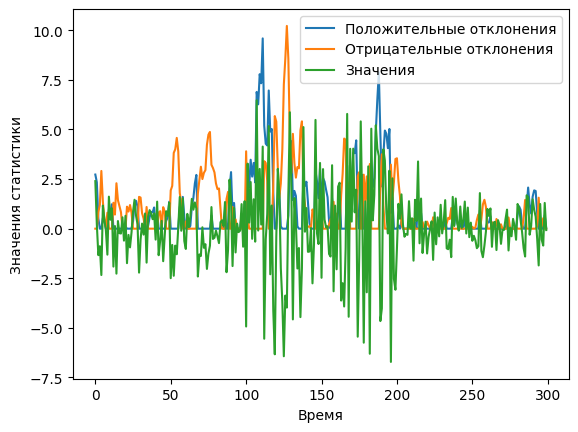

In [534]:
# Рост дисперсии

train = pd.Series(np.random.normal(loc=0, scale=1, size=300))
test =  pd.Series(np.hstack((
    np.random.normal(loc=0, scale=1, size=100),
    np.random.normal(loc=0, scale=3, size=100),
    np.random.normal(loc=0, scale=1, size=100),
)))

check_model(pd.Series(train), pd.Series(test), .02, .02, mean_diff = 1, threshold = 3, graphics = True)

plt.plot(test, label = 'Значения')
plt.legend()

Первый индекс разладки: 69
Переходим в ручной режим


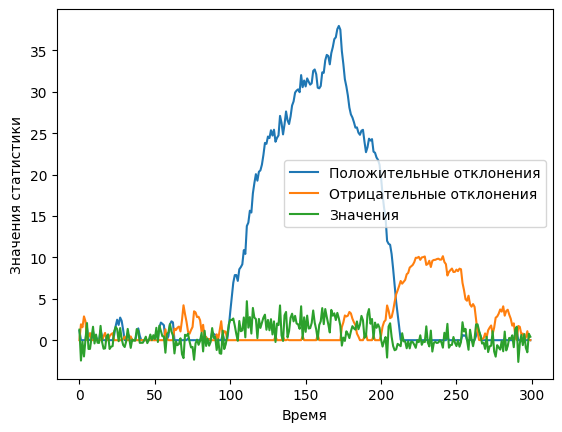

In [535]:
# Отклонения среднего

train = pd.Series(np.random.normal(loc=0, scale=1, size=300))
test =  pd.Series(np.hstack((
    np.random.normal(loc=0, scale=1, size=100),
    np.random.normal(loc=2, scale=1, size=100),
    np.random.normal(loc=0, scale=1, size=100),
)))

check_model(pd.Series(train), pd.Series(test), .02, .02, mean_diff = 1, threshold = 3, graphics = True)

plt.plot(test, label = 'Значения')
plt.legend()

А теперь на боевом датасете

Первая разладка через: 19
Переходим в ручной режим


19

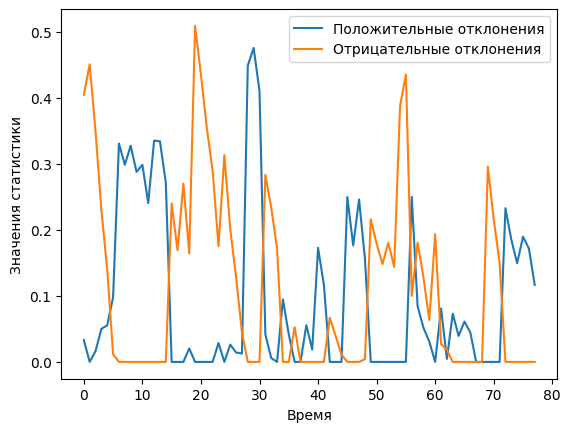

In [716]:
perfect_treshold = .5
perfect_mean_diff = y_train.std()

check_model(y_train, y_test_pred, .1, .1, mean_diff = perfect_mean_diff, threshold=perfect_treshold, graphics = True)

In [709]:
train = pd.read_excel('X_train.xlsx').dropna()
train.Date = pd.to_datetime(train.Date)
train = train.sort_values(by=['Date']).reset_index().drop(columns = ['index'])
test = pd.read_excel('X_out_of_time.xlsx').reset_index()
test.Date = pd.to_datetime(test.Date)
test = test.sort_values(by=['Date']).reset_index().drop(columns = ['index']).drop(columns = ['level_0'])

In [721]:
X_test = test.drop(columns = ['y_pred', 'y_true', 'Date'])
X_train = train.drop(columns = ['y_pred', 'y_true', 'Date'])

y_test = pd.DataFrame(test.y_pred)
y_test.columns = ['y_true']
y_train = pd.Series(train.y_true)

for i in range(len(X_test)):
    print(test.Date.iloc[i])
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.01, nthread=4, seed=1)
    xgb_model.fit(X_train, y_train)
    next_14_days_data = X_test.iloc[i:i+14]
    predictions = xgb_model.predict(next_14_days_data)
    check_model(y_train, predictions, .05, .05, mean_diff = 0.3, threshold=perfect_treshold, graphics = False)

    X_train = pd.concat([X_train, pd.DataFrame(X_test.loc[[i]])], axis = 0).reset_index().drop(columns = ['index'])
    y_train = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test.loc[[i]])], axis = 0).reset_index().drop(columns = ['index'])
    y_train = y_train.y_true

2020-11-02 00:00:00
Разладка не найдена
2020-11-03 00:00:00
Разладка не найдена
2020-11-04 00:00:00
Разладка не найдена
2020-11-05 00:00:00
Разладка не найдена
2020-11-06 00:00:00
Разладка не найдена
2020-11-07 00:00:00
Разладка не найдена
2020-11-08 00:00:00
Разладка не найдена
2020-11-09 00:00:00
Разладка не найдена
2020-11-10 00:00:00
Разладка не найдена
2020-11-11 00:00:00
Разладка не найдена
2020-11-12 00:00:00


KeyboardInterrupt: 